In [1]:
from data.image_pair_dataset import Paired_Dataset
from torchvision.transforms import transforms


data_dirs = ['./training_data/DIV2K_train_HR', './training_data/Flickr2K']
data = Paired_Dataset(image_directories=data_dirs, scale=2, patch_size=(500, 500))

hr, lr = data[470]
print(hr.shape, lr.shape)

to_pil = transforms.ToPILImage()

to_pil(hr).show()
to_pil(lr).show()

torch.Size([3, 1000, 1000]) torch.Size([3, 500, 500])


In [73]:
from data.get_loader import get_loader
from torchvision.transforms import transforms

data_dirs = ['./training_data/DIV2K_train_HR', './training_data/Flickr2K']
prefetcher = get_loader(image_directories=data_dirs,
                        scale=4,
                        patch_size=(96, 96),
                        batch_size=1,
                        device=None,
                        num_workers=2,
                        pin_memory=False,
                        prefetch_factor=2,
                        persistent_workers=True)


batch = prefetcher.next()
lr, hr = batch
print(lr.shape, hr.shape)
lr = lr.squeeze(0)
hr = hr.squeeze(0)
print(lr.shape, hr.shape)

to_pil = transforms.ToPILImage()

to_pil(hr).show()
to_pil(lr).show()

data prefetcher using device: cuda
data prefetcher initialized successfully
dataloader created successfully
torch.Size([1, 3, 96, 96]) torch.Size([1, 3, 384, 384])
torch.Size([3, 96, 96]) torch.Size([3, 384, 384])


In [6]:
import torch

dir = 'checkpoints/2X_IDRWKV_csplit_ft/iteration_500000.pt'
state_dict = torch.load(dir)

for key, value in state_dict.items():
    if key == 'finetuning':
        print(f"{key}: {value}")
state_dict['finetuning'] = False
torch.save(state_dict, dir)


finetuning: False


C:\Users\farns\AppData\Local\Temp\ipykernel_3956\418880573.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir)


In [12]:
import yaml
import torch
from arch.dirwkv import IDRWKV

device = torch.device('cuda')

with open('test_yamls/test.yaml', 'r') as f:
    config = yaml.safe_load(f)

model_config = config['model']
model = IDRWKV(
    img_size=model_config['patch_size'],
    num_blocks=model_config['num_blocks'],
    hidden_rate=model_config['hidden_rate'],
    patch_size=model_config['patch_size'],
    img_range=1,
    embed_dim=model_config['embed_dim'],
    upscale=model_config['scale'],
    n_head=model_config['num_heads']
).to(device)    

state = torch.load('checkpoints/3X_IDRWKV_fftloss_ft/iteration_10000.pt', map_location=device)['optimizer_state_dict']
for group, param in zip(state['param_groups'][0]['params'], model.parameters()):
    exp_avg = state['state'][group]['exp_avg']
    if exp_avg.shape != param.shape:
        print(param.shape, exp_avg.shape)
        break


C:\Users\farns\AppData\Local\Temp\ipykernel_30108\3123601556.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('checkpoints/3X_IDRWKV_fftloss_ft/iterat

torch.Size([64]) torch.Size([1, 1, 64])


In [26]:
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

img = Image.open('training_data/test.png').convert('RGB')
img = transforms.ToTensor()(img).unsqueeze(0)
# pooled = nn.AvgPool2d(4)(img)
pooled = TF.gaussian_blur(img, kernel_size=49, sigma=1.5)
pooled = nn.Upsample(size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False)(pooled)

hfd = img - pooled
# hfd = hfd.clamp(0, 1)
hfd = transforms.ToPILImage()(hfd.squeeze(0))
hfd.show()




In [76]:
import torch

model_file = torch.load('checkpoints/2X_IDRWKV_fftloss_ft/iteration_72000.pt', map_location='cpu')
state_dict = model_file['model_state_dict']

total_params = sum(param.numel() for param in state_dict.values())

print(f"number of model parameters: {total_params/1e6}M")
print(f"{'name':90s} {'mean':>12s} {'std':>12s} {'min':>12s} {'max':>12s}")
for name, t in state_dict.items():
    # if 'high_pass_weight' in name:
    # if 'gamma' in name:
            print(f'{name:90s} {t.mean():>12f} {t.std():>12f} {t.min():>12f} {t.max():>12f}')


number of model parameters: 0.385235M
name                                                                                               mean          std          min          max
conv_first.weight                                                                             -0.004213     0.198970    -1.097655     1.117360
conv_first.bias                                                                               -0.076358     0.360169    -0.766243     0.704755
patch_embed.norm.weight                                                                        1.014731     0.345287     0.378186     1.955796
patch_embed.norm.bias                                                                          0.063371     0.283799    -0.558853     0.617690
layers.0.conv1.net.0.weight                                                                    0.004120     0.230981    -1.628989     2.111748
layers.0.conv1.net.0.bias                                                                      0.042618 

C:\Users\farns\AppData\Local\Temp\ipykernel_10184\2726366264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_file = torch.load('checkpoints/2X_IDRWKV_fftloss_ft/it

C:\Users\farns\AppData\Local\Temp\ipykernel_8636\1764792349.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_file = torch.load(


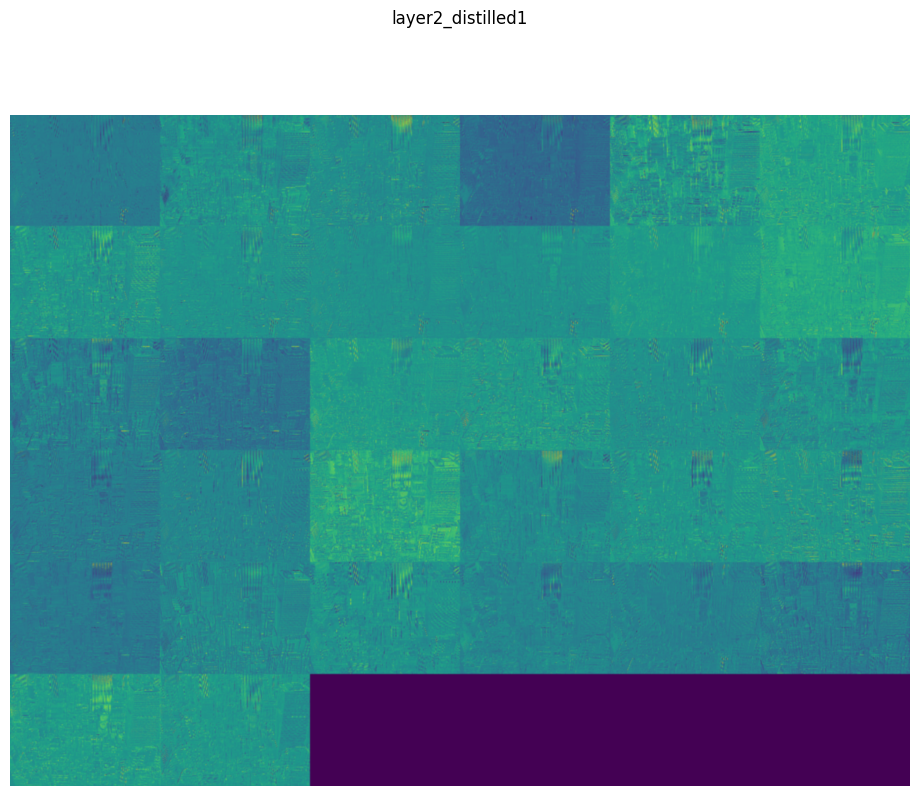

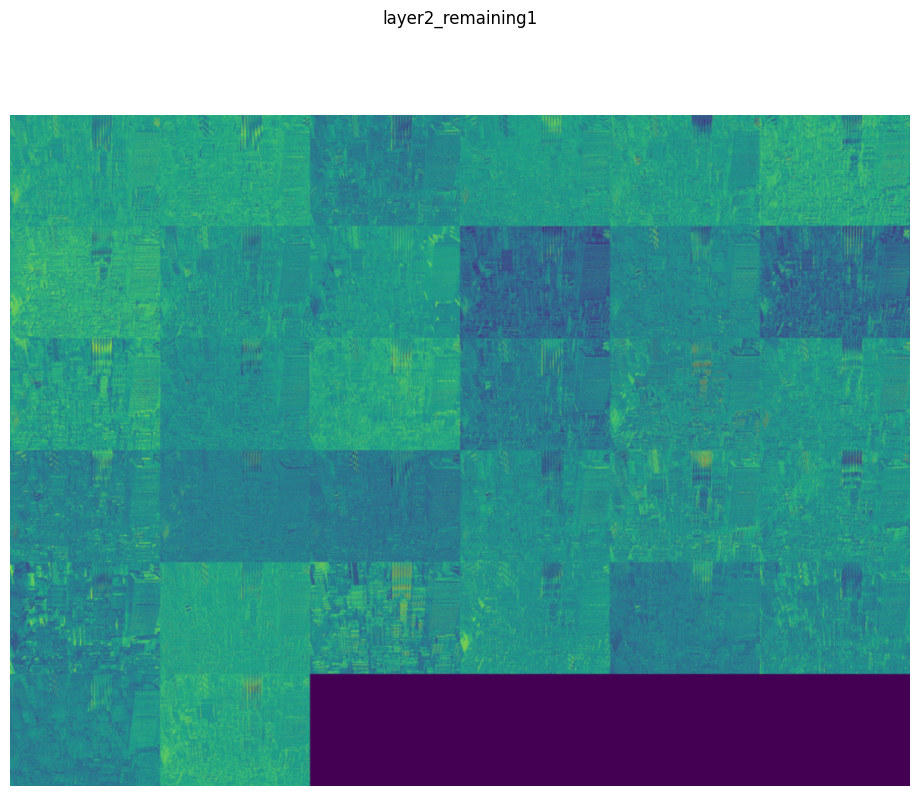

In [ ]:
import torch
import yaml
import math
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as T
# from arch.rwkv6srlite2 import RWKVIR
from arch.idrwkv import IDRWKV

device = "cuda"

# ---------- load image ----------
img = read_image("training_data/73_4x.png")
img = T.ConvertImageDtype(torch.float32)(img).unsqueeze(0).to(device)  # (1, C, H, W)

# ---------- load config ----------
config_path = "train_yamls/4X_IDRWKV_ft.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

model_config = config["model"]


# ---------- build model ----------
model = IDRWKV(
    img_size=model_config["patch_size"],
    num_blocks=model_config["num_blocks"],
    hidden_rate=model_config["hidden_rate"],
    patch_size=model_config["patch_size"],
    img_range=1,
    embed_dim=model_config["embed_dim"],
    upscale=model_config["scale"],
    n_head=model_config["num_heads"],
    with_cp=model_config["with_cp"],
).to(device)

# ---------- load weights ----------
model_file = torch.load(
    "checkpoints/4X_IDRWKV/iteration_100000.pt",
    map_location="cpu",
)
state_dict = model_file["model_state_dict"]
model.load_state_dict(state_dict, strict=False)
model.eval()

# ---------- hook setup ----------
features = {}

def get_activation(name):
    def hook(module, input, output):
        # store on CPU to avoid GPU memory bloat
        features[name] = output.detach().cpu()
    return hook


# conv_after_body = model.conv_after_body[4]
# conv_after_body.register_forward_hook(get_activation("conv_after_body_0"))

# conv_first = model.conv_first
# conv_first.register_forward_hook(get_activation("conv_first_0"))

# layer2_distilled1 = model.layers[2].distill1
# layer2_distilled1.register_forward_hook(get_activation("layer2_distilled1"))

# layer2_remaining1 = model.layers[2].remain1
# layer2_remaining1.register_forward_hook(get_activation("layer2_remaining1"))

layer_2_distilled2 = model.layers[2].distill2
layer_2_distilled2.register_forward_hook(get_activation("layer2_distilled2"))

layer_2_remaining2 = model.layers[2].remain2
layer_2_remaining2.register_forward_hook(get_activation("layer2_remaining2"))



layer_2_input = model.layers[2].conv1
layer_2_input.register_forward_hook(get_activation("layer_2_input"))

# layer_2_output = model.layers[2].esa
# layer_2_output.register_forward_hook(get_activation("layer_2_output"))

with torch.no_grad():
    _ = model(img)

# ---------- visualization ----------
def show_feature_maps(activation, num_maps=64, title_prefix="", iteration=None):
    # activation: (B, C, H, W) or (C, H, W)
    if activation.dim() == 4:
        activation = activation[0]  # (C, H, W)

    C, H, W = activation.shape

    rows, cols = math.ceil(math.sqrt(num_maps)), math.ceil(num_maps / math.ceil(math.sqrt(num_maps)))
    grid_size = rows * cols
    num_maps = min(num_maps, C, grid_size)

    # Make a big canvas: (rows*H, cols*W)
    big = torch.zeros(rows * H, cols * W, dtype=activation.dtype)

    for i in range(num_maps):
        r = i // cols
        c = i % cols

        fmap = activation[i]
        mn, mx = fmap.min(), fmap.max()
        if mx > mn:
            fmap = (fmap - mn) / (mx - mn)

        big[r*H:(r+1)*H, c*W:(c+1)*W] = fmap

    fig_scale = 1.5

    fig = plt.figure(figsize=(cols * fig_scale, rows * fig_scale))

    # One single axes, full figure
    ax = fig.add_axes([0, 0, 1, 1])  # [left, bottom, width, height] in figure coords
    ax.imshow(big.cpu().numpy(), cmap="viridis", interpolation="bicubic")
    ax.axis("off")

    if title_prefix:

        fig.suptitle(title_prefix + (f" (Iteration {iteration})" if iteration is not None else ""), y=0.99)

    plt.show()

# show_feature_maps(features["layer_2_input"], num_maps=64, title_prefix="layer_2_input")
# show_feature_maps(features["layer_2_output"], num_maps=16, title_prefix="layer_2_output")

# show_feature_maps(features["conv_first_0"], num_maps=64, title_prefix="conv_first_0")
# show_feature_maps(features["conv_after_body_0"], num_maps=64, title_prefix="conv_after_body_0")

# show_feature_maps(features["layer2_distilled1"], num_maps=32, title_prefix="layer2_distilled1")
# show_feature_maps(features["layer2_remaining1"], num_maps=32, title_prefix="layer2_remaining1")

show_feature_maps(features["layer2_distilled2"], num_maps=16, title_prefix="layer2_distilled2")
show_feature_maps(features["layer2_remaining2"], num_maps=16, title_prefix="layer2_remaining2")

In [4]:
import cv2

# img = cv2.imread("testing_data/HR/Urban100/x4/img_011_HR_x4.png")
img = cv2.imread("testing_data/HR/Urban100/x4/img_073_HR_x4.png")

# coordinates of your crop region
x1, y1 = 20, 530
x2, y2 = 120, 630

# draw a red rectangle (BGR: (0,0,255))
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), thickness=3)

cv2.imwrite("test_outputs/HR_74_outlined.png", img)

True